In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

input_shape = (128, 128, 3)
num_classes = 10

model = create_cnn_model(input_shape, num_classes)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

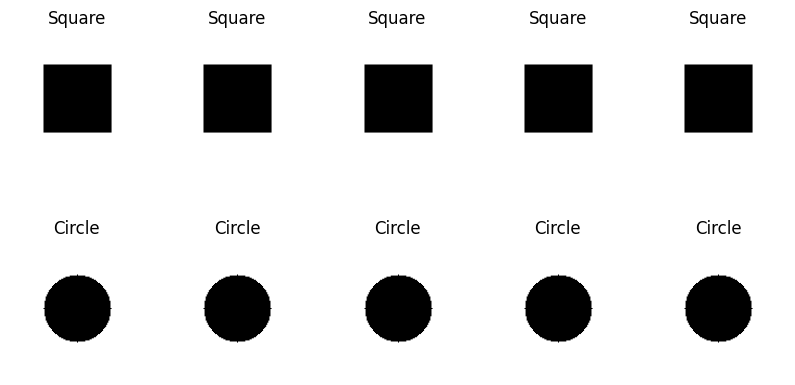

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_square(size, color=(255, 255, 255)):
    image = np.zeros((size, size, 3), dtype=np.uint8)
    image[:, :] = color
    side_length = size // 2
    center = size // 2
    top_left = (center - side_length // 2, center - side_length // 2)
    bottom_right = (center + side_length // 2, center + side_length // 2)
    cv2.rectangle(image, top_left, bottom_right, (0, 0, 0), thickness=-1)
    return image

def generate_circle(size, color=(255, 255, 255)):
    image = np.zeros((size, size, 3), dtype=np.uint8)
    image[:, :] = color
    center = (size // 2, size // 2)
    radius = size // 4
    cv2.circle(image, center, radius, (0, 0, 0), thickness=-1)
    return image

num_images_per_class = 5
image_size = 128

square_images = [generate_square(image_size) for _ in range(num_images_per_class)]
circle_images = [generate_circle(image_size) for _ in range(num_images_per_class)]

plt.figure(figsize=(10, 5))

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, i + 1)
    plt.imshow(square_images[i])
    plt.title('Square')
    plt.axis('off')

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, num_images_per_class + i + 1)
    plt.imshow(circle_images[i])
    plt.title('Circle')
    plt.axis('off')

plt.show()


In [3]:
def preprocess_images(images):
    preprocessed_images = np.array(images) / 255.0
    return preprocessed_images

preprocessed_square_images = preprocess_images(square_images)
preprocessed_circle_images = preprocess_images(circle_images)

square_predictions = model.predict(preprocessed_square_images)
circle_predictions = model.predict(preprocessed_circle_images)

square_predicted_classes = np.argmax(square_predictions, axis=1)
circle_predicted_classes = np.argmax(circle_predictions, axis=1)

print("Predicted classes for squares:", square_predicted_classes)
print("Predicted classes for circles:", circle_predicted_classes)


1/1 [==============================] - 0s 212ms/step
Predicted classes for squares: [0 0 0 0 0]
Predicted classes for circles: [0 0 0 0 0]


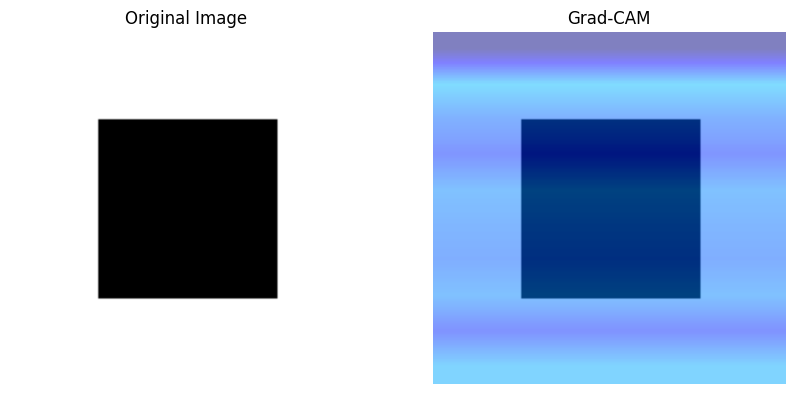

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def generate_grad_cam(model, image, layer_name):
    img_array = np.expand_dims(image, axis=0)
    preprocessed_img = img_array / 255.0  

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(preprocessed_img)
        loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)[0]

    guided_grads = tf.cast(conv_outputs > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    conv_outputs = conv_outputs[0]
    guided_grads = guided_grads.numpy()

    weights = np.mean(guided_grads, axis=(0, 1))

    conv_outputs = np.reshape(conv_outputs, (-1, conv_outputs.shape[-1]))
    weights = np.expand_dims(weights, axis=0)

    cam = np.dot(conv_outputs.T, weights.T)
    cam = np.squeeze(cam)

    cam = np.maximum(cam, 0)  
    cam /= np.max(cam)  

    return cam

image_index = 0  
image = square_images[image_index]

cam = generate_grad_cam(model, image, 'dense_1')

cam = cv2.resize(cam, (image.shape[1], image.shape[0]))

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

cam_image = cv2.addWeighted(heatmap, 0.5, image, 0.5, 0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('Grad-CAM')
plt.axis('off')

plt.show()
